# Problem Statement

## Goal
Pre-process Tissue Sample to Identify ISUP GRADE and Gleanson Score (Majority and Minority) 

## Steps
1. RGB to GrayScale
2. Thresholding to convert to Binary Image
3. Crop Image - using Polynomial Boundary Representation Principle (to reduce computation and time)
4. Closing to enhace Gleason pattern
5. Using Local processing to identify Eulers Number of patches
6. Create regions using Split And Merge & Eulers Number
7. Identify Majority and Minorit Regions
8. Ouput Segmented Tissue Sample and Maj & Min Eulers Score

# Imports

In [1]:
! pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
import skimage.io as io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from osgeo import gdal
import cv2
import mahotas
import pickle

In [8]:
import numpy as np
import pandas as pd

# Loading Data

In [9]:
path = '/content/0005f7aaab2800f6170c399693a96917.tiff'
cimg = cv2.imread(path)

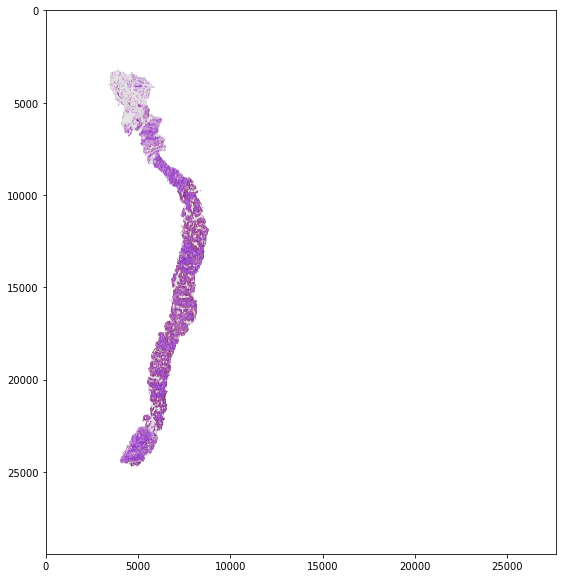

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cimg)

## Rough Crop to reduce processing time

In [10]:
# rough crop
cimg = cimg[2000:26000, 2500:11000]
cimg.shape

(24000, 8500, 3)

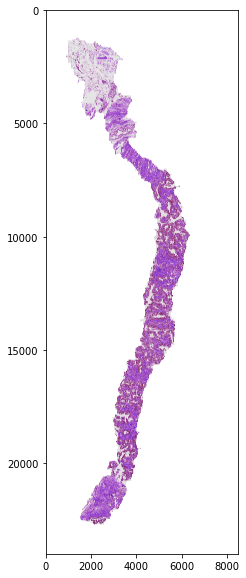

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cimg)

# Step 1: RGB to GrayScale

In [11]:
img = cv2.cvtColor(cimg, cv2.COLOR_RGB2GRAY)

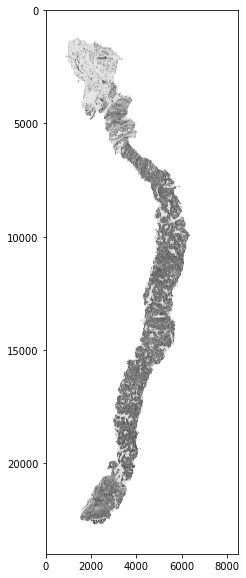

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')

In [12]:
del cimg

# Step 2: Adaptive Thresholding using Histogram to convert to Binary Image

(array([1.20100000e+03, 1.18995000e+05, 1.16651900e+06, 3.32040100e+06,
        5.65192000e+06, 4.56499100e+06, 3.35020400e+06, 2.30148300e+06,
        6.44341500e+06, 1.77080871e+08]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

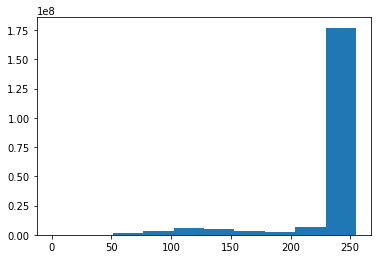

In [ ]:
plt.hist(img.flatten())

### Ideal threshold - between 150 to 200

In [13]:
# thresholding using cv2

ret,img_t200 = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
img_adp = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 2)

Text(0.5, 1.0, 'Adaptive Thresholding - Gaussian')

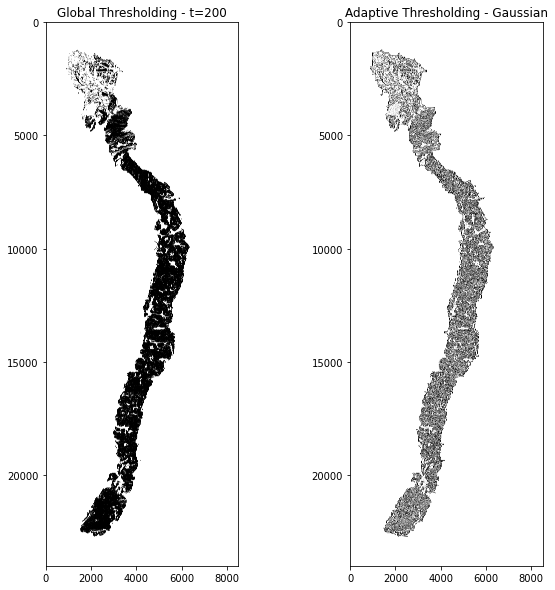

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(img_t200, cmap='gray')
plt.title("Global Thresholding - t=200")

plt.subplot(1,2,2)
plt.imshow(img_adp, cmap='gray')
plt.title("Adaptive Thresholding - Gaussian")

### Using Adaptive Thresholdign due to varying pigmentation on tissue caused by dye

# Step 3: Cropping image usign Polygonal Boundary Representation

In [14]:
img = img_adp

In [15]:
del img_adp, img_t200

In [ ]:
max_i = 0
min_i = 0

In [ ]:
for i in range(2500):
  if len(np.unique(img[i])) != 1:
         min_i = i
         break
print(min_i)

1200


In [ ]:
for i in range(img.shape[0]-1, img.shape[0]-2501, -1):
  if len(np.unique(img[i])) != 1:
         max_i = i
         break
print(max_i)

22703


#### Therefore Extreme points on y axis - 1200 & 22703

In [ ]:
max_j = 0
min_j = 0

In [ ]:
for j in range(2000):
  if len(np.unique(img[:, j])) != 1:
         min_j = j
         break
print(min_j)

876


In [ ]:
for j in range(img.shape[1]-1, img.shape[1]-2501, -1):
  if len(np.unique(img[:, j])) != 1:
         max_j = j
         break
print(max_j)

6331


#### Therefore Extreme points on x axis - 876 & 6331

#### With a buffer of 10 pixels
#### Polygon Formed by - p1(1190, 866), p2(1190, 6341), p3(22713, 6341), p4(22713, 866)

In [16]:
x1, x2 = 1190, 22713
y1, y2 = 866, 6341

In [17]:
fin_img = img[x1:x2]
fin_img = fin_img[:, y1:y2]

In [18]:
img = fin_img

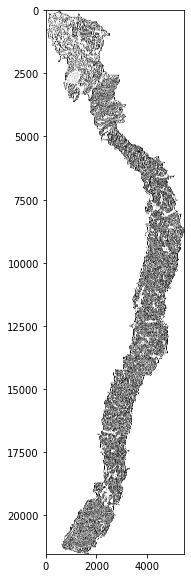

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')

In [19]:
del fin_img

# Step 4: Closing to Enhance Gleason Pattern

In [20]:
kernel = np.ones((15,15),np.uint8)

In [ ]:
patch1 = img[:1000, :1000]
patch1 = cv2.bitwise_not(patch1) # invert levels

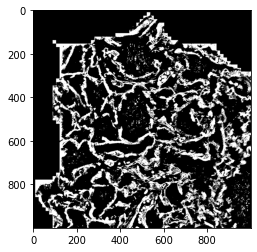

In [ ]:
plt.imshow(patch1, cmap='gray')

## Comparing Opening, Closing, Dilation, Erosion

In [ ]:
img_d = cv2.dilate(patch1, kernel, iterations = 1)
img_e = cv2.erode(patch1, kernel, iterations = 1)

img_op = cv2.morphologyEx(patch1, cv2.MORPH_OPEN, kernel)
img_cl = cv2.morphologyEx(patch1, cv2.MORPH_CLOSE, kernel)

Text(0.5, 1.0, 'Closing')

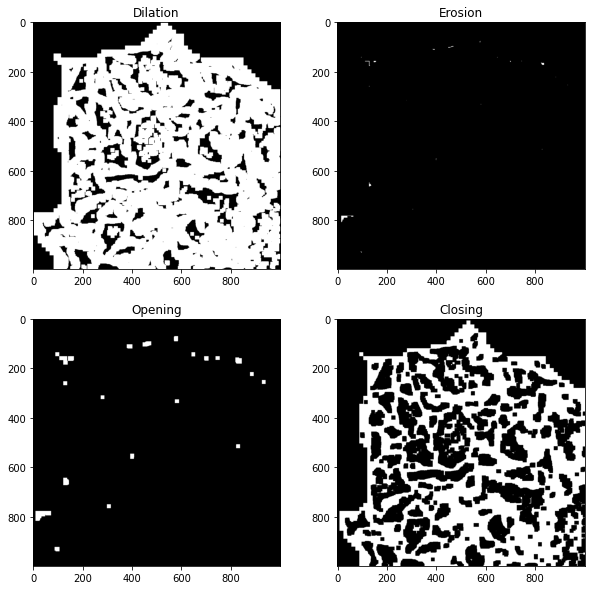

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(img_d, cmap='gray')
plt.title("Dilation")

plt.subplot(2,2,2)
plt.imshow(img_e, cmap='gray')
plt.title("Erosion")

plt.subplot(2,2,3)
plt.imshow(img_op, cmap='gray')
plt.title("Opening")

plt.subplot(2,2,4)
plt.imshow(img_cl, cmap='gray')
plt.title("Closing")

### Closing gives clear boundary and defined patterns

In [21]:
img = cv2.morphologyEx(cv2.bitwise_not(img), cv2.MORPH_CLOSE, kernel)

In [ ]:
del img_d, img_e, img_op, img_cl

# Step 5: Local Processign to find Gleason Score

## Testing the concpet

In [ ]:
patch1 = img[:1000, :1000]
patch1 = patch1 == 255

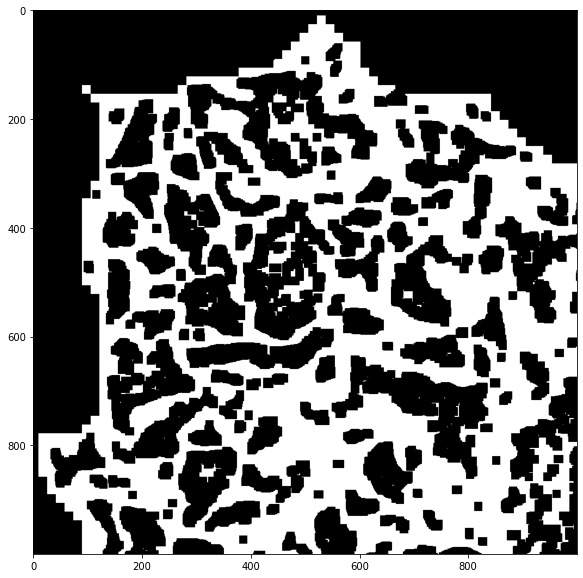

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(patch1, cmap='gray')

In [ ]:
euler = mahotas.euler(patch1)
euler

-49.0

## Pipline to perform the above proccess on all patches

In [22]:
def get_eulers_number_for_patch(patch):
  patch = patch == 255
  euler = mahotas.euler(patch)
  return euler

In [23]:
def generate_patches_and_process(img, kernel_size):
  
  prev_i, prev_j = 0, 0
  pes = np.zeros(((int(img.shape[0]/kernel_size)+1), (int(img.shape[1]/kernel_size)+1)))
  # print(f"size={(int(img.shape[0]/1000)+1)}, {(int(img.shape[1]/1000)+1)}")

  for i in range(kernel_size, img.shape[0], kernel_size):
    
    prev_j = 0
    for j in range(kernel_size, img.shape[1], kernel_size):

      pe = get_eulers_number_for_patch(img[prev_i:i, prev_j:j])
      pes[prev_i//kernel_size][prev_j//kernel_size] = pe

      # print(f"{prev_i}:{i}, {prev_j}:{j} - ind=({prev_i//kernel_size},{prev_j//kernel_size}) -> eu num={pe} -> {pes[prev_i//kernel_size][prev_j//kernel_size]} \n")

      prev_j = j
    
    # remaining j
    pe = get_eulers_number_for_patch(img[prev_i:i, prev_j:img.shape[1]])
    pes[prev_i//kernel_size][prev_j//kernel_size] = pe

    # print(f"{prev_i}:{i}, {prev_j}:{img.shape[1]} - ind=({prev_i//kernel_size},{prev_j//kernel_size}) -> eu num={pe} -> {pes[prev_i//kernel_size][prev_j//kernel_size]} \n")
    # print(pes)

    prev_i = i
  
  # remaining i
  prev_j = 0
  for j in range(kernel_size, img.shape[1], kernel_size):

      pe = get_eulers_number_for_patch(img[prev_i:img.shape[0], prev_j:j])
      pes[prev_i//kernel_size][prev_j//kernel_size] = pe

      prev_j = j
    
  # remaining j
  pe = get_eulers_number_for_patch(img[prev_i:i, prev_j:img.shape[1]])
  pes[prev_i//kernel_size][prev_j//kernel_size] = pe

  return pes

In [24]:
img_eu_nums_500 = generate_patches_and_process(img, 500)
img_eu_nums_1000 = generate_patches_and_process(img, 1000)

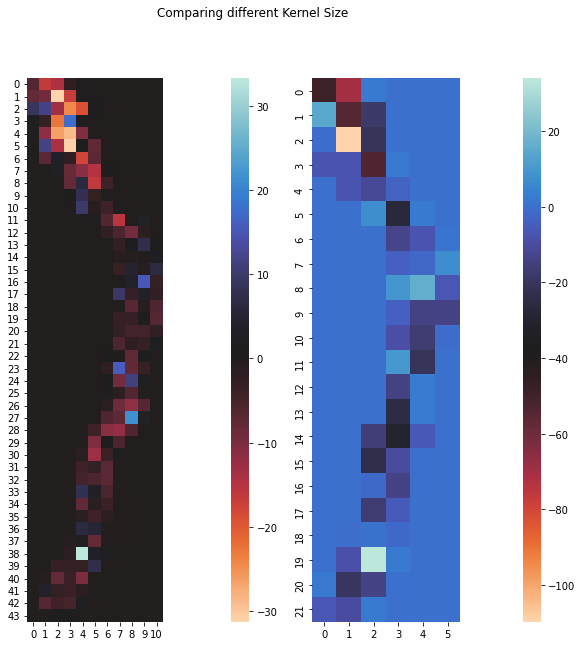

In [74]:
fig, (ax1,axcb1,ax2,axcb2) = plt.subplots(1,4, figsize=(10,10), gridspec_kw={'width_ratios':[1,0.08,1,0.08]})
fig.suptitle('Comparing different Kernel Size')

sns.heatmap(img_eu_nums_500, cmap='icefire_r', square=True, ax=ax1, cbar_ax=axcb1)

sns.heatmap(img_eu_nums_1000, cmap='icefire_r', square=True, ax=ax2, cbar_ax=axcb2)

#### For a more accurate comaprision, we need to scale all euler numbers based on kernel size (as greater the kernel size, greater the eulers number)

### Using kernel size 500, for more detail

In [25]:
del img_eu_nums_1000

# Step 6: Split & Merge

## Generate Image from Eulers number

In [26]:
def get_eu_segs(eu_nums, kernel_size, shape):

  # print(eu_nums.shape)

  segs = np.zeros(shape)
  i = 0

  for r in eu_nums:
    j = 0
    for e in r:
      # print(j, (min(kernel_size, img.shape[0]-i), min(kernel_size, img.shape[1]-j)))
      segs[i:min(i+kernel_size, img.shape[0]), j:min(j+kernel_size, img.shape[1])] = np.ones((min(kernel_size, img.shape[0]-i), min(kernel_size, img.shape[1]-j))) * e
      j += kernel_size
    i += kernel_size
  
  return segs

In [27]:
seg_img = get_eu_segs(img_eu_nums_500, 500, img.shape)

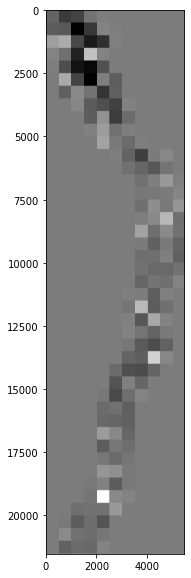

In [93]:
plt.figure(figsize=(10,10))
plt.imshow(seg_img, cmap='gray')

## Split and Merge Segementation using K-means

In [28]:
seg_img_f = seg_img.reshape((-1, 1))
seg_img_f = np.float32(seg_img_f)

In [29]:
seg_img_f.shape

(117838425, 1)

In [30]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
attempts=10

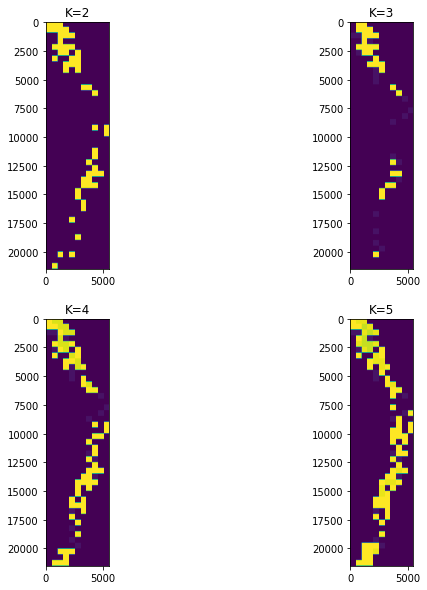

In [26]:
plt.figure(figsize=(10,10))

for i in range(2, 6):
  ret,label,center=cv2.kmeans(seg_img_f, i, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((seg_img.shape))

  plt.subplot(2,2, i-1)
  plt.imshow(result_image)
  plt.title(f"K={i}")

In [27]:
del result_image, label, center, ret, res

### Using K=5

In [31]:
K = 5

In [32]:
ret,label,center=cv2.kmeans(seg_img_f, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

# Step 7: Identify Majority and Minority Eulers Number

In [33]:
label = label.reshape(seg_img.shape)

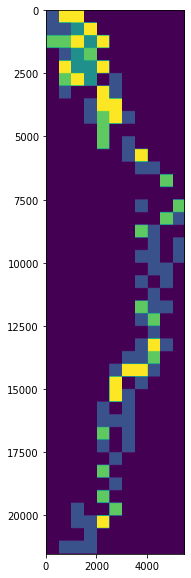

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(label, vmin=0, vmax=4)

In [63]:
# purple - 0
# blue - 1
# light blue - 2
# green - 3
# yellow - 4

## Finding Region wise Euler's Number Using Custom Masks

#### Ignoring Region 0 - background

In [65]:
# Masks for all clusters
l = label.flatten()
eu_c1 = l == 1
eu_c2 = l == 2
eu_c3 = l == 3
eu_c4 = l == 4

Text(0.5, 1.0, 'Cluster 4')

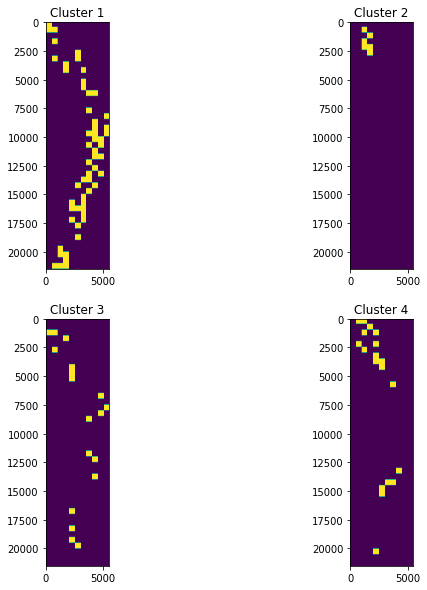

In [74]:
# Visualising Masks
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(eu_c1.reshape(label.shape), vmin=0, vmax=1)
plt.title("Cluster 1")

plt.subplot(2,2,2)
plt.imshow(eu_c2.reshape(label.shape), vmin=0, vmax=1)
plt.title("Cluster 2")

plt.subplot(2,2,3)
plt.imshow(eu_c3.reshape(label.shape), vmin=0, vmax=1)
plt.title("Cluster 3")

plt.subplot(2,2,4)
plt.imshow(eu_c4.reshape(label.shape), vmin=0, vmax=1)
plt.title("Cluster 4")

In [66]:
# Cluster 1
count1 = np.sum(eu_c1)
eu_c1 = eu_c1.reshape(label.shape)
eu_c1 = np.multiply(eu_c1,seg_img)
eu_sc_c1 = np.sum(eu_c1)
eu_sc_c1

-79743750.0

In [68]:
# Cluster 2
count2 = np.sum(eu_c2)
eu_c2 = eu_c2.reshape(label.shape)
eu_c2 = np.multiply(eu_c2,seg_img)
eu_sc_c2 = np.sum(eu_c2)
eu_sc_c2

-40937500.0

In [69]:
# Cluster 3
count3 = np.sum(eu_c3)
eu_c3 = eu_c3.reshape(label.shape)
eu_c3 = np.multiply(eu_c3,seg_img)
eu_sc_c3 = np.sum(eu_c3)
eu_sc_c3

54356250.0

In [70]:
# Cluster 4
count4 = np.sum(eu_c4)
eu_c4 = eu_c4.reshape(label.shape)
eu_c4 = np.multiply(eu_c4,seg_img)
eu_sc_c4 = np.sum(eu_c4)
eu_sc_c4

-64562500.0

In [75]:
# Scaled Euler's Score which can be Mapped to Gleason Score
print("Cluster 1: ", eu_sc_c1/count1)
print("Cluster 2: ", eu_sc_c2/count2)
print("Cluster 3: ", eu_sc_c3/count3)
print("Cluster 4: ", eu_sc_c4/count4)

Cluster 1:  -5.711280214861236
Cluster 2:  -27.291666666666668
Cluster 3:  12.112813370473537
Cluster 4:  -13.592105263157896


In [93]:
print("Area of Region 1: ",count1)
print("Area of Region 2: ",count2)
print("Area of Region 3: ",count3)
print("Area of Region 4: ",count4)

Area of Region 1:  13962500
Area of Region 2:  1500000
Area of Region 3:  4487500
Area of Region 4:  4750000


# Step 8: Outputing Segmented Tissue Sample

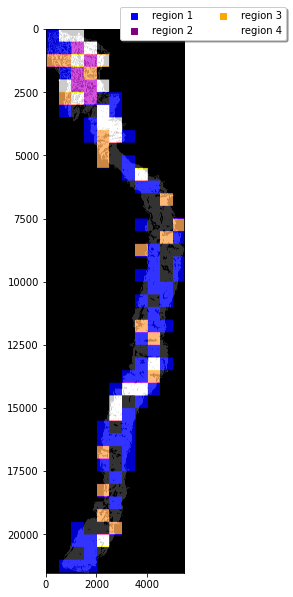

In [91]:
fig = plt.figure(figsize = (10,10))
ax = plt.subplot(111)

plt.imshow(img, cmap='gray')
plt.imshow(label, vmin=0, vmax=4, alpha=0.8, cmap='gnuplot2', )

region_1 = mlines.Line2D([], [], color='blue', marker='s', ls='', label='region 1')
region_2 = mlines.Line2D([], [], color='purple', marker='s', ls='', label='region 2')
region_3 = mlines.Line2D([], [], color='orange', marker='s', ls='', label='region 3')
region_4 = mlines.Line2D([], [], color='white', marker='s', ls='', label='region 4')

ax.legend(handles=[region_1, region_2, region_3, region_4], loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)

# Further Analysis of Segmented Tissue Sample


# Conclusion

1. 4 Regions were Identified in the Tissue Sample
2. On Further Analysis of the 4 region the Majority and Minority Gleason Patterns were Identified
3. Then using a Scoring Index these Patterns were mapped to correct Gleason Score
4. The ISUP Grade for the Tissue Sample was Identified

# Challenges:
1. Reading in a tiff file
2. Reducing Time and Computationaly Complexity without Down Sampling
3. Converting to Binary Image using correct Thresholding Approach
4. Enhancing Gleason Pattern (Evaluating the performance of different Morphologiccal Operations)
5. Implementing Segmentation using custom value - Euler's Number not the pixel values
6. Identifying the correct K value for Segmentation
7. Calculating Euler's Score for each Region